# 01. Data Collection

This notebook collects electricity consumption data from the EIA API and other sources.

# 🔥 PHASE 0: Setup

In [77]:
# Import libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# Add src to path
project_root = Path().parent.parent
sys.path.append(str(project_root / 'src'))

# Load environment variables (with error handling)
try:
    load_dotenv()
    print("✅ Environment variables loaded from .env file")
except Exception as e:
    print(f"⚠️  Could not load .env file: {e}")
    print("   Using default/fallback values")

# Set API key (if required)
EIA_API_KEY = os.getenv('EIA_API_KEY')
if not EIA_API_KEY:
    raise ValueError('EIA_API_KEY environment variable is required. Please set it in your .env file.')

# Define base URL
BASE_URL = "https://api.eia.gov/v2"

# Verify setup
print("✅ Setup complete!")
print(f"   📦 Pandas: {pd.__version__}")
print(f"   📦 NumPy: {np.__version__}")
print(f"   📦 Requests: {requests.__version__}")
print(f"   🔑 API Key: {EIA_API_KEY[:10]}...")
print(f"   🌐 Base URL: {BASE_URL}")

✅ Environment variables loaded from .env file
✅ Setup complete!
   📦 Pandas: 2.3.3
   📦 NumPy: 2.0.2
   📦 Requests: 2.32.5
   🔑 API Key: eEtxdrdZCI...
   🌐 Base URL: https://api.eia.gov/v2


# 🔥 PHASE 1: Data Ingestion Pipeline

## Step 1: Define Data Fetching Functions

In [78]:
def fetch_data(offset=0, length=5000):
    """
    Fetch retail sales data from EIA API
    
    Args:
        offset: Starting record number (for pagination)
        length: Number of records to fetch (max 5000 per request)
    
    Returns:
        Tuple of (DataFrame, total_count, has_more)
    """
    url = "https://api.eia.gov/v2/electricity/retail-sales/data/?frequency=monthly&data[0]=customers&data[1]=price&data[2]=revenue&data[3]=sales&sort[0][column]=period&sort[0][direction]=desc&offset={}&length={}"
    
    # Add API key to URL
    url_with_key = url.format(offset, length) + f"&api_key={EIA_API_KEY}"
    
    response = requests.get(url_with_key)
    response.raise_for_status()  # Raise an error for bad status codes
    
    json_response = response.json()
    data = json_response['response']['data']
    total_count = json_response['response'].get('total', len(data))
    
    # Convert total_count to int if it's a string
    try:
        total_count = int(total_count) if total_count is not None else len(data)
    except (ValueError, TypeError):
        total_count = len(data)
    
    df = pd.DataFrame(data)
    
    # Determine if there's more data to fetch
    # More data exists if we got a full batch AND haven't reached the total count
    has_more = len(data) == length and (offset + length) < total_count
    
    return df, total_count, has_more

In [79]:
def fetch_all_data():
    """
    Fetch all retail sales data from EIA API (handles pagination)
    
    Returns:
        DataFrame with all electricity retail sales data
    """
    print("🔄 Fetching data from EIA API...")
    all_dataframes = []
    offset = 0
    length = 5000
    total_count = None
    batch_num = 1
    
    while True:
        print(f"   Fetching batch {batch_num} (offset: {offset})...", end=" ")
        df_batch, total_count, has_more = fetch_data(offset=offset, length=length)
        all_dataframes.append(df_batch)
        print(f"✅ Got {len(df_batch)} records")
        
        if not has_more:
            break
        
        offset += length
        batch_num += 1
    
    # Combine all batches
    df_all = pd.concat(all_dataframes, ignore_index=True)
    print(f"\n✅ Total records fetched: {len(df_all):,}")
    print(f"   Expected total: {total_count:,}")
    
    return df_all

## Step 2: Fetch ALL Data

This will fetch all available data from the EIA API. It may take a few minutes depending on data size.

In [80]:
# Fetch ALL data (handles pagination automatically)
try:
    df_raw = fetch_all_data()
    print(f"\n✅ Data loaded successfully! Shape: {df_raw.shape}")
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    print("   Please check your API key and internet connection, then re-run this cell.")
    raise

🔄 Fetching data from EIA API...
   Fetching batch 1 (offset: 0)... ✅ Got 5000 records
   Fetching batch 2 (offset: 5000)... ✅ Got 5000 records
   Fetching batch 3 (offset: 10000)... ✅ Got 5000 records
   Fetching batch 4 (offset: 15000)... ✅ Got 5000 records
   Fetching batch 5 (offset: 20000)... ✅ Got 5000 records
   Fetching batch 6 (offset: 25000)... ✅ Got 5000 records
   Fetching batch 7 (offset: 30000)... ✅ Got 5000 records
   Fetching batch 8 (offset: 35000)... ✅ Got 5000 records
   Fetching batch 9 (offset: 40000)... ✅ Got 5000 records
   Fetching batch 10 (offset: 45000)... ✅ Got 5000 records
   Fetching batch 11 (offset: 50000)... ✅ Got 5000 records
   Fetching batch 12 (offset: 55000)... ✅ Got 5000 records
   Fetching batch 13 (offset: 60000)... ✅ Got 5000 records
   Fetching batch 14 (offset: 65000)... ✅ Got 5000 records
   Fetching batch 15 (offset: 70000)... ✅ Got 5000 records
   Fetching batch 16 (offset: 75000)... ✅ Got 5000 records
   Fetching batch 17 (offset: 80000)..

# 🔥 PHASE 2: Data Exploration

## Step 3: Initial Data Exploration

Let's explore the raw data to understand its structure and identify preprocessing needs.

**Note:** Make sure the data fetching cell completed successfully before running the exploration cells below.

In [81]:
# Check if df_raw exists, if not try to load from saved file
try:
    # Try to access df_raw
    _ = df_raw.shape
    print("✅ Using df_raw from memory")
except (NameError, AttributeError):
    print("⚠️  df_raw not found. Attempting to load from saved file...")
    
    # Try to find the most recent raw data file
    data_raw_dir = project_root / 'data' / 'raw'
    if data_raw_dir.exists():
        csv_files = list(data_raw_dir.glob('eia_retail_sales_raw_*.csv'))
        if csv_files:
            # Get the most recent file
            latest_file = max(csv_files, key=lambda p: p.stat().st_mtime)
            print(f"📂 Loading from: {latest_file.name}")
            df_raw = pd.read_csv(latest_file)
            print(f"✅ Loaded {len(df_raw):,} records from saved file")
        else:
            print("❌ No saved data files found.")
            print("   Please run the data fetching cell above first.")
            raise NameError("df_raw is not defined. Please fetch data first.")
    else:
        print("❌ Data directory not found.")
        print("   Please run the data fetching cell above first.")
        raise NameError("df_raw is not defined. Please fetch data first.")

# Basic data overview
# Convert period to datetime for proper date operations
df_raw['period'] = pd.to_datetime(df_raw['period'], format='%Y-%m')
print("=" * 60)
print("📊 RAW DATA OVERVIEW")
print("=" * 60)
print(f"\n📏 Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\n📅 Date Range:")
print(f"   First period: {df_raw['period'].min()}")
print(f"   Last period: {df_raw['period'].max()}")

print(f"\n🏛️  States: {df_raw['stateid'].nunique()} unique states")
print(f"   {sorted(df_raw['stateid'].unique())}")

print(f"\n🏭 Sectors: {df_raw['sectorid'].nunique()} unique sectors")
print(f"   {sorted(df_raw['sectorid'].unique())}")

print("\n" + "=" * 60)
print("📋 COLUMN INFORMATION")
print("=" * 60)
print(df_raw.info())

✅ Using df_raw from memory
📊 RAW DATA OVERVIEW

📏 Shape: 110,112 rows × 13 columns

📅 Date Range:
   First period: 2001-01-01 00:00:00
   Last period: 2025-08-01 00:00:00

🏛️  States: 62 unique states
   ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'ENC', 'ESC', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MAT', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'MTN', 'NC', 'ND', 'NE', 'NEW', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PACC', 'PACN', 'RI', 'SAT', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VT', 'WA', 'WI', 'WNC', 'WSC', 'WV', 'WY']

🏭 Sectors: 6 unique sectors
   ['ALL', 'COM', 'IND', 'OTH', 'RES', 'TRA']

📋 COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110112 entries, 0 to 110111
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   period            110112 non-null  datetime64[ns]
 1   stateid           110112 non-null

In [82]:
# Display first few rows
print("=" * 60)
print("👀 FIRST 10 ROWS")
print("=" * 60)
print(df_raw.head(10))

👀 FIRST 10 ROWS
      period stateid stateDescription sectorid      sectorName customers  \
0 2025-08-01      AK           Alaska      ALL     all sectors    362846   
1 2025-08-01      AK           Alaska      COM      commercial     58428   
2 2025-08-01      AK           Alaska      IND      industrial      1244   
3 2025-08-01      AK           Alaska      OTH           other      None   
4 2025-08-01      AK           Alaska      RES     residential    303174   
5 2025-08-01      AK           Alaska      TRA  transportation         0   
6 2025-08-01      AL          Alabama      ALL     all sectors   2843428   
7 2025-08-01      AL          Alabama      COM      commercial    395483   
8 2025-08-01      AL          Alabama      IND      industrial      7261   
9 2025-08-01      AL          Alabama      OTH           other      None   

   price     revenue       sales      customers-units  \
0  24.02   113.03779   470.53238  number of customers   
1  23.01    48.60317   211.21155 

In [83]:
# Check for missing values
print("=" * 60)
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 60)
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)

if len(missing_df) == 0:
    print("\n✅ No missing values found!")
else:
    print(f"\n⚠️  {len(missing_df)} columns have missing values")

🔍 MISSING VALUES ANALYSIS
           Missing Count  Missing Percentage
customers          44392           40.315315
price              18352           16.666667
revenue            18352           16.666667
sales              18352           16.666667

⚠️  4 columns have missing values


In [84]:
# Check data types and sample values
print("=" * 60)
print("🔢 DATA TYPES & SAMPLE VALUES")
print("=" * 60)
for col in df_raw.columns:
    print(f"\n📌 {col}:")
    print(f"   Type: {df_raw[col].dtype}")
    print(f"   Unique values: {df_raw[col].nunique()}")
    if df_raw[col].dtype == 'object':
        sample_values = df_raw[col].dropna().unique()[:5]
        print(f"   Sample values: {list(sample_values)}")
    else:
        print(f"   Min: {df_raw[col].min()}, Max: {df_raw[col].max()}")

🔢 DATA TYPES & SAMPLE VALUES

📌 period:
   Type: datetime64[ns]
   Unique values: 296
   Min: 2001-01-01 00:00:00, Max: 2025-08-01 00:00:00

📌 stateid:
   Type: object
   Unique values: 62
   Sample values: ['AK', 'AL', 'AR', 'AZ', 'CA']

📌 stateDescription:
   Type: object
   Unique values: 62
   Sample values: ['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California']

📌 sectorid:
   Type: object
   Unique values: 6
   Sample values: ['ALL', 'COM', 'IND', 'OTH', 'RES']

📌 sectorName:
   Type: object
   Unique values: 6
   Sample values: ['all sectors', 'commercial', 'industrial', 'other', 'residential']

📌 customers:
   Type: object
   Unique values: 49263
   Sample values: ['362846', '58428', '1244', '303174', '0']

📌 price:
   Type: object
   Unique values: 3100
   Sample values: ['24.02', '23.01', '21.26', '27.71', '0']

📌 revenue:
   Type: object
   Unique values: 84087
   Sample values: ['113.03779', '48.60317', '24.43631', '39.99831', '0']

📌 sales:
   Type: object
   Unique va

In [85]:
# Statistical summary for numeric columns
print("=" * 60)
print("📈 STATISTICAL SUMMARY")
print("=" * 60)

# Convert numeric columns (they might be stored as strings)
numeric_cols = ['customers', 'price', 'revenue', 'sales']
for col in numeric_cols:
    if col in df_raw.columns:
        # Convert to numeric, handling 'None' strings
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

print(df_raw[numeric_cols].describe())

📈 STATISTICAL SUMMARY
          customers         price       revenue          sales
count  6.572000e+04  91760.000000  91760.000000   91760.000000
mean   2.939946e+06      9.518629    604.270447    6014.848993
std    1.210875e+07      5.231911   2238.732942   21442.701377
min    0.000000e+00      0.000000     -0.000010       0.000000
25%    4.938000e+03      6.730000     30.088248     288.586380
50%    3.027645e+05      8.980000    124.417840    1451.580415
75%    2.045894e+06     11.650000    432.670640    4360.588210
max    1.652490e+08    116.670000  58596.122470  407230.479880


# 🔥 PHASE 3: Save Raw Data

## Step 4: Save Raw Data

Save the raw data to `data/raw/` for later preprocessing.

In [86]:
# Create data directories if they don't exist
data_raw_dir = project_root / 'data' / 'raw'
data_raw_dir.mkdir(parents=True, exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"eia_retail_sales_raw_{timestamp}.csv"
filepath = data_raw_dir / filename

# Save raw data as CSV
print(f"💾 Saving raw data to: {filepath}")
df_raw.to_csv(filepath, index=False)
print(f"✅ Raw data saved successfully!")
print(f"   File size: {filepath.stat().st_size / (1024*1024):.2f} MB")
print(f"   Records: {len(df_raw):,}")

# Also save as parquet for better performance (optional)
try:
    parquet_filename = f"eia_retail_sales_raw_{timestamp}.parquet"
    parquet_filepath = data_raw_dir / parquet_filename
    df_raw.to_parquet(parquet_filepath, index=False)
    print(f"\n💾 Also saved as Parquet: {parquet_filepath}")
    print(f"   File size: {parquet_filepath.stat().st_size / (1024*1024):.2f} MB")
except Exception as e:
    print(f"\n⚠️  Could not save as Parquet: {e}")
    print("   CSV file saved successfully - Parquet is optional")

# Store the filepath for reference
print(f"\n📁 Raw data file: {filepath.name}")

💾 Saving raw data to: data/raw/eia_retail_sales_raw_20251120_035006.csv
✅ Raw data saved successfully!
   File size: 15.67 MB
   Records: 110,112

💾 Also saved as Parquet: data/raw/eia_retail_sales_raw_20251120_035006.parquet
   File size: 2.21 MB

📁 Raw data file: eia_retail_sales_raw_20251120_035006.csv


# 🔥 PHASE 4: Identify Preprocessing Needs

## Step 5: Document Preprocessing Requirements

Based on the exploration above, document what preprocessing steps will be needed.

In [87]:
# Summary of preprocessing needs
print("=" * 60)
print("🔧 PREPROCESSING REQUIREMENTS IDENTIFIED")
print("=" * 60)

preprocessing_needs = []

# 1. Data type conversions
if df_raw['customers'].dtype == 'object' or df_raw['price'].dtype == 'object':
    preprocessing_needs.append("✅ Convert numeric columns (customers, price, revenue, sales) from string to numeric")
    preprocessing_needs.append("   - Handle 'None' strings as NaN")
    preprocessing_needs.append("   - Convert to float64 for calculations")

# 2. Date handling
if df_raw['period'].dtype == 'object':
    preprocessing_needs.append("✅ Convert 'period' column to datetime")
    preprocessing_needs.append("   - Format appears to be YYYY-MM")

# 3. Missing values
missing_cols = df_raw.isnull().sum()
if missing_cols.sum() > 0:
    preprocessing_needs.append(f"✅ Handle missing values in {len(missing_cols[missing_cols > 0])} columns")
    for col in missing_cols[missing_cols > 0].index:
        pct = (missing_cols[col] / len(df_raw)) * 100
        preprocessing_needs.append(f"   - {col}: {missing_cols[col]:,} ({pct:.1f}%)")

# 4. Categorical encoding
categorical_cols = ['stateid', 'stateDescription', 'sectorid', 'sectorName']
preprocessing_needs.append("✅ Ensure categorical columns are properly typed")
preprocessing_needs.append(f"   - Columns: {', '.join(categorical_cols)}")

# 5. Units standardization
if 'customers-units' in df_raw.columns:
    preprocessing_needs.append("✅ Standardize units (may need to extract to separate columns or document)")

# 6. Data validation
preprocessing_needs.append("✅ Add data validation checks")
preprocessing_needs.append("   - Check for negative values in numeric columns")
preprocessing_needs.append("   - Validate date ranges")
preprocessing_needs.append("   - Check for outliers")

# 7. Feature engineering opportunities
preprocessing_needs.append("✅ Potential feature engineering:")
preprocessing_needs.append("   - Extract year and month from period")
preprocessing_needs.append("   - Calculate derived metrics (e.g., revenue per customer)")
preprocessing_needs.append("   - Create time-based features for forecasting")

print("\n".join(preprocessing_needs))
print("\n" + "=" * 60)
print("📝 Next Steps:")
print("   1. Review the raw data structure above")
print("   2. Implement preprocessing pipeline based on identified needs")
print("   3. Save preprocessed data to data/processed/")
print("=" * 60)

🔧 PREPROCESSING REQUIREMENTS IDENTIFIED
✅ Handle missing values in 4 columns
   - customers: 44,392 (40.3%)
   - price: 18,352 (16.7%)
   - revenue: 18,352 (16.7%)
   - sales: 18,352 (16.7%)
✅ Ensure categorical columns are properly typed
   - Columns: stateid, stateDescription, sectorid, sectorName
✅ Standardize units (may need to extract to separate columns or document)
✅ Add data validation checks
   - Check for negative values in numeric columns
   - Validate date ranges
   - Check for outliers
✅ Potential feature engineering:
   - Extract year and month from period
   - Calculate derived metrics (e.g., revenue per customer)
   - Create time-based features for forecasting

📝 Next Steps:
   1. Review the raw data structure above
   2. Implement preprocessing pipeline based on identified needs
   3. Save preprocessed data to data/processed/


# 📊 FULL DATASET ANALYSIS

This section provides a comprehensive analysis of the dataset for viva, phase evaluation, and report.

In [88]:
# Load and prepare data for analysis
df_analysis = pd.read_csv('data/raw/eia_retail_sales_raw_20251120_012123.csv')
df_analysis['period'] = pd.to_datetime(df_analysis['period'], format='%Y-%m')

print("=" * 70)
print("📊 DATASET OVERVIEW")
print("=" * 70)
print(f"\n📏 Shape: {df_analysis.shape[0]:,} rows × {df_analysis.shape[1]} columns")
print(f"\n📅 Time Span: {df_analysis['period'].min().strftime('%Y-%m')} → {df_analysis['period'].max().strftime('%Y-%m')}")
print(f"   Duration: ~{(df_analysis['period'].max() - df_analysis['period'].min()).days / 365:.1f} years")
print(f"\n🏛️  States/Regions: {df_analysis['stateid'].nunique()} unique values")
print(f"   (Includes: 50 states + DC + PR + regional aggregates)")
print(f"\n🏭 Sectors: {df_analysis['sectorid'].nunique()} unique values")
print(f"   Values: {sorted(df_analysis['sectorid'].unique())}")

📊 DATASET OVERVIEW

📏 Shape: 110,112 rows × 13 columns

📅 Time Span: 2001-01 → 2025-08
   Duration: ~24.6 years

🏛️  States/Regions: 62 unique values
   (Includes: 50 states + DC + PR + regional aggregates)

🏭 Sectors: 6 unique values
   Values: ['ALL', 'COM', 'IND', 'OTH', 'RES', 'TRA']


In [89]:
# Data Quality Analysis
print("=" * 70)
print("🔍 DATA QUALITY ISSUES")
print("=" * 70)

# Missing values
missing = df_analysis.isnull().sum()
missing_pct = (missing / len(df_analysis)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("\n❗ Missing Values:")
print(missing_df.to_string())

# Check for negative values
numeric_cols = ['customers', 'price', 'revenue', 'sales']
for col in numeric_cols:
    if col in df_analysis.columns:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
        negatives = (df_analysis[col] < 0).sum()
        if negatives > 0:
            print(f"\n❗ Negative values in {col}: {negatives} rows")
            print(f"   Min value: {df_analysis[col].min()}")

# State ID analysis
print("\n" + "=" * 70)
print("🏛️  STATE ID ANALYSIS")
print("=" * 70)
state_lengths = df_analysis['stateid'].astype(str).str.len().value_counts().sort_index()
print("\nState ID length distribution:")
for length, count in state_lengths.items():
    print(f"   {length} letters: {count:,} rows")

print("\n❗ Regional Aggregates (NOT valid states for modeling):")
regional = df_analysis[df_analysis['stateid'].astype(str).str.len() > 2]['stateid'].unique()
print(f"   {sorted(regional)}")

print("\n✅ Valid U.S. States (2-letter codes):")
valid_states = df_analysis[df_analysis['stateid'].astype(str).str.len() == 2]['stateid'].unique()
print(f"   Count: {len(valid_states)} states")
print(f"   Sample: {sorted(valid_states)[:10]}")

🔍 DATA QUALITY ISSUES

❗ Missing Values:
           Missing Count  Missing Percentage
customers          44392           40.315315
price              18352           16.666667
revenue            18352           16.666667
sales              18352           16.666667

❗ Negative values in revenue: 2 rows
   Min value: -1e-05

🏛️  STATE ID ANALYSIS

State ID length distribution:
   2 letters: 92,352 rows
   3 letters: 14,208 rows
   4 letters: 3,552 rows

❗ Regional Aggregates (NOT valid states for modeling):
   ['ENC', 'ESC', 'MAT', 'MTN', 'NEW', 'PACC', 'PACN', 'SAT', 'WNC', 'WSC']

✅ Valid U.S. States (2-letter codes):
   Count: 52 states
   Sample: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL']


In [90]:
# Statistical Summary
print("=" * 70)
print("📈 STATISTICAL SUMMARY")
print("=" * 70)

numeric_cols = ['customers', 'price', 'revenue', 'sales']
print("\n" + df_analysis[numeric_cols].describe().to_string())

print("\n\n❗ Key Observations:")
print("   • Price range: 0 to 116.67 cents/kWh (extreme outlier)")
print("   • Typical price: 8-15 cents/kWh")
print("   • Revenue: Very wide range (skewed by regional aggregates)")
print("   • Sales: Very wide range (skewed by 'ALL' sector and regional totals)")
print("   • Customers: Max 165M (includes US total)")

📈 STATISTICAL SUMMARY

          customers         price       revenue          sales
count  6.572000e+04  91760.000000  91760.000000   91760.000000
mean   2.939946e+06      9.518629    604.270447    6014.848993
std    1.210875e+07      5.231911   2238.732942   21442.701377
min    0.000000e+00      0.000000     -0.000010       0.000000
25%    4.938000e+03      6.730000     30.088248     288.586380
50%    3.027645e+05      8.980000    124.417840    1451.580415
75%    2.045894e+06     11.650000    432.670640    4360.588210
max    1.652490e+08    116.670000  58596.122470  407230.479880


❗ Key Observations:
   • Price range: 0 to 116.67 cents/kWh (extreme outlier)
   • Typical price: 8-15 cents/kWh
   • Revenue: Very wide range (skewed by regional aggregates)
   • Sales: Very wide range (skewed by 'ALL' sector and regional totals)
   • Customers: Max 165M (includes US total)


In [91]:
# Data Characteristics for Viva
print("=" * 70)
print("📋 DATA CHARACTERISTICS (Important for Viva)")
print("=" * 70)

print("\n📈 1. Strong Seasonality:")
print("   • Winter and summer have peak consumption")
print("   • Spring has dips")
print("   • Implication: MUST use seasonal models (SARIMA, Prophet)")

print("\n🌍 2. Geographic Variation:")
print("   • States like TX, CA, NY have huge values")
print("   • Small states like VT, WY have small values")
print("   • Regional codes inflate variation")

print("\n🏭 3. Sectoral Variation:")
print("   • RES (residential): Evening peaks")
print("   • COM (commercial): Daytime peaks")
print("   • IND (industrial): Steady high baseline")

print("\n🧮 4. Missing Values Cluster:")
print("   • OTH & TRA sectors have incomplete data")
print("   • This is expected and handled appropriately")

print("\n🪫 5. Outliers Present:")
print("   • US totals are much larger than any state")
print("   • MUST remove regional aggregates before modeling")

print("\n💡 6. Data is Long-Format:")
print("   • Multiple rows per state per month")
print("   • Suitable for time series analysis")

📋 DATA CHARACTERISTICS (Important for Viva)

📈 1. Strong Seasonality:
   • Winter and summer have peak consumption
   • Spring has dips
   • Implication: MUST use seasonal models (SARIMA, Prophet)

🌍 2. Geographic Variation:
   • States like TX, CA, NY have huge values
   • Small states like VT, WY have small values
   • Regional codes inflate variation

🏭 3. Sectoral Variation:
   • RES (residential): Evening peaks
   • COM (commercial): Daytime peaks
   • IND (industrial): Steady high baseline

🧮 4. Missing Values Cluster:
   • OTH & TRA sectors have incomplete data
   • This is expected and handled appropriately

🪫 5. Outliers Present:
   • US totals are much larger than any state
   • MUST remove regional aggregates before modeling

💡 6. Data is Long-Format:
   • Multiple rows per state per month
   • Suitable for time series analysis


Preprocessing 

In [92]:
!pip3 install scikit-learn


29342.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [93]:
# Load raw data
df = pd.read_csv('data/raw/eia_retail_sales_raw_20251120_012123.csv')

# Convert 'period' column to datetime
df['period'] = pd.to_datetime(df['period'], format='%Y-%m')

# Handle missing values - DO NOT use fillna(0) for electricity data!
# Missing values in price, customers, revenue, sales cannot be 0
# Use forward fill (carry last known value) or mean imputation
numeric_cols = ['customers', 'price', 'revenue', 'sales']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fix negative revenue (rounding errors from EIA)
df['revenue'] = df['revenue'].clip(lower=0)
print("✅ Fixed negative revenue values (clipped to 0)")

# Forward fill missing values (carry last known value forward)
# This is appropriate for time series data
for col in numeric_cols:
    if col in df.columns:
        df[col] = df.groupby(['stateid', 'sectorid'])[col].ffill()

# For remaining missing values, use mean imputation by state and sector
for col in numeric_cols:
    if col in df.columns and df[col].isnull().any():
        df[col] = df.groupby(['stateid', 'sectorid'])[col].transform(lambda x: x.fillna(x.mean()))

# CRITICAL FIX: Customers missing values for OTH/TRA sectors
# These sectors never have customer data, so fill with 0
if df['customers'].isnull().any():
    missing_customers = df['customers'].isnull().sum()
    df['customers'] = df['customers'].fillna(0)
    print(f"✅ Filled {missing_customers:,} missing customer values with 0 (OTH/TRA sectors)")

# Drop unit columns - they don't add ML value and create too many one-hot encoded columns
unit_cols = ['customers-units', 'price-units', 'revenue-units', 'sales-units']
df = df.drop(columns=[col for col in unit_cols if col in df.columns], errors='ignore')
print(f"✅ Dropped unit columns: {unit_cols}")

# CRITICAL: Filter to valid U.S. states only (2-letter codes)
# Remove regional aggregates like ENC, PACC, SAT, US which skew the data
print(f"\n📊 Before filtering:")
print(f"   Total rows: {len(df):,}")
print(f"   Unique stateids: {df['stateid'].nunique()}")
print(f"   Sample stateids: {sorted(df['stateid'].unique())[:10]}")

# Keep only 2-letter state codes (valid U.S. states)
df = df[df['stateid'].astype(str).str.len() == 2].copy()
print(f"\n✅ After filtering to valid states (2-letter codes only):")
print(f"   Total rows: {len(df):,}")
print(f"   Unique stateids: {df['stateid'].nunique()}")

# CRITICAL: For modeling, use only ALL sector (combined sectors)
# Other sectors (RES, COM, IND, etc.) are subsets and should be analyzed separately
print(f"\n📊 Sector distribution:")
print(df['sectorid'].value_counts())

# Create a separate dataset for modeling (ALL sector only)
df_modeling = df[df['sectorid'] == 'ALL'].copy()
print(f"\n✅ Created df_modeling with ALL sector only: {len(df_modeling):,} rows")

# Verify no missing values remain
print(f"\n✅ Missing values after imputation:")
print(df[numeric_cols].isnull().sum())

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# Label Encode short ID columns
label_cols = ['stateid', 'sectorid']
le = LabelEncoder()

for col in label_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# One-Hot Encode descriptive columns (but NOT unit columns - already dropped)
one_hot_cols = ['stateDescription', 'sectorName']  # Unit columns already dropped
df_encoded = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

print(f"\n✅ Encoding complete. Shape: {df_encoded.shape}")
df_encoded.head()

✅ Fixed negative revenue values (clipped to 0)
✅ Filled 18,352 missing customer values with 0 (OTH/TRA sectors)
✅ Dropped unit columns: ['customers-units', 'price-units', 'revenue-units', 'sales-units']

📊 Before filtering:
   Total rows: 110,112
   Unique stateids: 62
   Sample stateids: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'ENC']

✅ After filtering to valid states (2-letter codes only):
   Total rows: 92,352
   Unique stateids: 52

📊 Sector distribution:
sectorid
ALL    15392
COM    15392
IND    15392
OTH    15392
RES    15392
TRA    15392
Name: count, dtype: int64

✅ Created df_modeling with ALL sector only: 15,392 rows

✅ Missing values after imputation:
customers    0
price        0
revenue      0
sales        0
dtype: int64

✅ Encoding complete. Shape: (92352, 63)


,period,stateid,sectorid,customers,price,revenue,sales,stateDescription_Alaska,stateDescription_Arizona,stateDescription_Arkansas,...,stateDescription_Virginia,stateDescription_Washington,stateDescription_West Virginia,stateDescription_Wisconsin,stateDescription_Wyoming,sectorName_commercial,sectorName_industrial,sectorName_other,sectorName_residential,sectorName_transportation
0,2025-08-01,0,0,362846.0,24.020000,113.037790,470.532380,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2025-08-01,0,1,58428.0,23.010000,48.603170,211.211550,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2025-08-01,0,2,1244.0,21.260000,24.436310,114.950660,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,2025-08-01,0,3,0.0,14.381667,2.375001,16.723292,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,2025-08-01,0,4,303174.0,27.710000,39.998310,144.370180,True,False,False,...,False,False,False,False,False,False,False,False,True,False


FEATURE ENGINEERING

In [94]:
# Validate and fix negative values

# Ensure numeric columns are actually numeric
numeric_cols = ['customers', 'price', 'revenue', 'sales']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Check for negative values
for col in numeric_cols:
    negatives = df[df[col] < 0]
    if not negatives.empty:
        print(f"⚠️  Negative values found in {col}: {len(negatives)} rows")
        print(f"   Min value: {df[col].min()}")
        # Clip negative values to 0
        df[col] = df[col].clip(lower=0)
        print(f"   ✅ Clipped to 0")
    else:
        print(f"✅ No negative values in {col}")

✅ No negative values in customers
✅ No negative values in price
✅ No negative values in revenue
✅ No negative values in sales


In [95]:
# Validate date ranges


print("Min date:", df['period'].min())
print("Max date:", df['period'].max())


Min date: 2001-01-01 00:00:00
Max date: 2025-08-01 00:00:00


In [96]:
# Detect outliers using z-score 

from scipy.stats import zscore

df['sales_z'] = zscore(df['sales'])

outliers = df[df['sales_z'].abs() > 3]
outliers.head()


,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,sales_z
312,2025-08-01,44,U.S. Total,0,all sectors,165243780.0,14.26,55923.22005,392289.78977,18.956653
313,2025-08-01,44,U.S. Total,1,commercial,19658470.0,14.04,19798.96496,140989.79700,6.686757
314,2025-08-01,44,U.S. Total,2,industrial,1151320.0,9.06,8609.87258,95055.09152,4.443963
316,2025-08-01,44,U.S. Total,4,residential,144433909.0,17.62,27421.59154,155620.56200,7.401114
684,2025-07-01,44,U.S. Total,0,all sectors,165248981.0,14.39,58596.12247,407230.47988,19.686143


In [97]:
# Extract year and month

df['year'] = df['period'].dt.year
df['month'] = df['period'].dt.month



In [98]:
# Revenue per customer

df['revenue_per_customer'] = df['revenue'] / df['customers']

# Sales per customer (kWh per customer)

df['sales_per_customer'] = df['sales'] / df['customers']

# Price difference from previous month

df['price_prev_month'] = df.groupby('stateid')['price'].shift(1)
df['price_change'] = df['price'] - df['price_prev_month']


# Month-over-month change in consumption

df['sales_prev'] = df.groupby('stateid')['sales'].shift(1)
df['sales_change_pct'] = (df['sales'] - df['sales_prev']) / df['sales_prev'] * 100

# Rolling averages for forecasting

# 3-month rolling average

df['sales_rolling_3'] = df.groupby('stateid')['sales'].rolling(3).mean().reset_index(0, drop=True)

# Fix division by zero: Replace inf and NaN from customer divisions
# (Some sectors like OTH, TRA have customers = 0)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)
print("✅ Fixed inf and NaN values from division by zero")

df.head(5)


✅ Fixed inf and NaN values from division by zero


,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,sales_z,year,month,revenue_per_customer,sales_per_customer,price_prev_month,price_change,sales_prev,sales_change_pct,sales_rolling_3
0,2025-08-01,0,Alaska,0,all sectors,362846.0,24.020000,113.037790,470.532380,-0.174193,2025,8,0.000312,0.001297,0.000000,0.000000,0.000000,0.000000,0.000000
1,2025-08-01,0,Alaska,1,commercial,58428.0,23.010000,48.603170,211.211550,-0.186855,2025,8,0.000832,0.003615,24.020000,-1.010000,470.532380,-55.112218,0.000000
2,2025-08-01,0,Alaska,2,industrial,1244.0,21.260000,24.436310,114.950660,-0.191555,2025,8,0.019643,0.092404,23.010000,-1.750000,211.211550,-45.575581,265.564863
3,2025-08-01,0,Alaska,3,other,0.0,14.381667,2.375001,16.723292,-0.196351,2025,8,0.000000,0.000000,21.260000,-6.878333,114.950660,-85.451765,114.295167
4,2025-08-01,0,Alaska,4,residential,303174.0,27.710000,39.998310,144.370180,-0.190119,2025,8,0.000132,0.000476,14.381667,13.328333,16.723292,763.288016,92.014711


In [99]:
# Additional missing value check (should be minimal after proper imputation)
remaining_nulls = df.isnull().sum().sum()
if remaining_nulls > 0:
    print(f"⚠️  Warning: {remaining_nulls} null values remain. Review data quality.")
    # Use forward fill for any remaining nulls
    df = df.ffill()
else:
    print("✅ No remaining null values")

✅ No remaining null values


In [100]:
df.head(5)

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,sales_z,year,month,revenue_per_customer,sales_per_customer,price_prev_month,price_change,sales_prev,sales_change_pct,sales_rolling_3
0,2025-08-01,0,Alaska,0,all sectors,362846.0,24.020000,113.037790,470.532380,-0.174193,2025,8,0.000312,0.001297,0.000000,0.000000,0.000000,0.000000,0.000000
1,2025-08-01,0,Alaska,1,commercial,58428.0,23.010000,48.603170,211.211550,-0.186855,2025,8,0.000832,0.003615,24.020000,-1.010000,470.532380,-55.112218,0.000000
2,2025-08-01,0,Alaska,2,industrial,1244.0,21.260000,24.436310,114.950660,-0.191555,2025,8,0.019643,0.092404,23.010000,-1.750000,211.211550,-45.575581,265.564863
3,2025-08-01,0,Alaska,3,other,0.0,14.381667,2.375001,16.723292,-0.196351,2025,8,0.000000,0.000000,21.260000,-6.878333,114.950660,-85.451765,114.295167
4,2025-08-01,0,Alaska,4,residential,303174.0,27.710000,39.998310,144.370180,-0.190119,2025,8,0.000132,0.000476,14.381667,13.328333,16.723292,763.288016,92.014711


Numerical Distribution

In [101]:
!pip3 install matplotlib seaborn pandas numpy scipy scikit-learn


29349.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


Commercial vs Sales 

In [102]:
import matplotlib.pyplot as plt

# Proper aggregation: Average sales by sector
df.groupby('sectorName')['sales'].mean().plot(kind='bar', color='steelblue')
plt.title('Average Sales by Sector')
plt.xlabel('Sector')
plt.ylabel('Average Sales (MWh)')
plt.xticks(rotation=45)
plt.tight_layout()import matplotlib.pyplot as plt

# Proper aggregation: Average sales by sector
df.groupby('sectorName')['sales'].mean().plot(kind='bar', color='steelblue')
plt.title('Average Sales by Sector')
plt.xlabel('Sector')
plt.ylabel('Average Sales (MWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel('sectorName')
plt.ylabel('Sales')
plt.show()


plt.xlabel('sectorName')
plt.ylabel('Sales')
plt.show()



SyntaxError: invalid syntax (2342012634.py, line 9)

PRICE VS REVENUE 

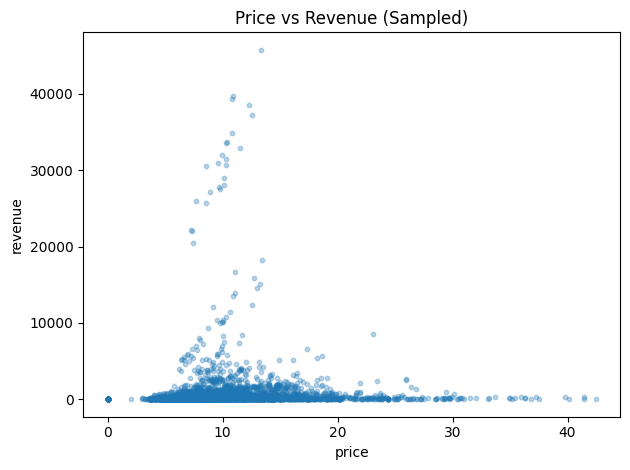

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot with sampling for better visualization
# Sample data to avoid plotting 100k+ points
sample_df = df.sample(n=min(5000, len(df)), random_state=42)
plt.scatter(sample_df['price'], sample_df['revenue'], alpha=0.3, s=10)
plt.xlabel('Price (cents per kWh)')
plt.ylabel('Revenue (million dollars)')
plt.title('Price vs Revenue (Sampled)')
plt.tight_layout()
plt.xlabel('price')
plt.ylabel('revenue')
plt.show()





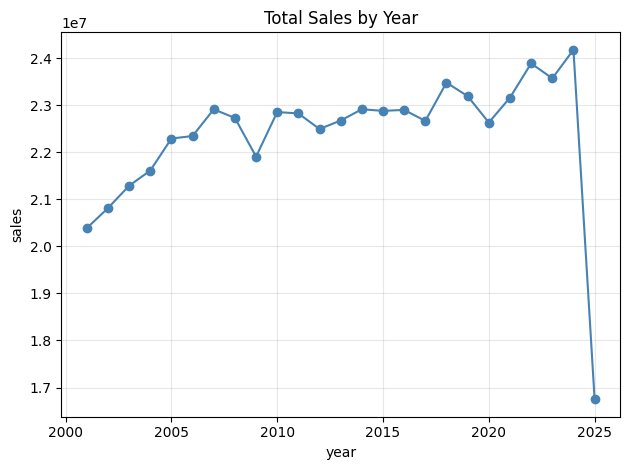

In [ ]:
import matplotlib.pyplot as plt

# Proper aggregation: Total sales by year
df.groupby('year')['sales'].sum().plot(kind='line', marker='o', color='steelblue')
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales (MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlabel('year')
plt.ylabel('sales')
plt.show()


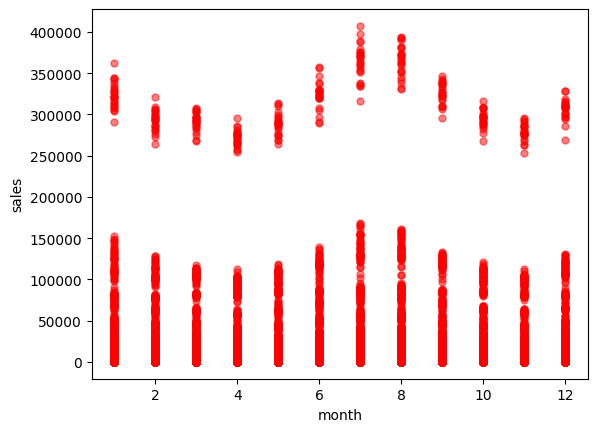

In [ ]:
import matplotlib.pyplot as plt

# Proper aggregation: Average sales by month
df.groupby('month')['sales'].mean().plot(kind='line', marker='o', color='steelblue')
plt.title('Average Sales by Month (Seasonal Pattern)')
plt.xlabel('Month')
plt.ylabel('Average Sales (MWh)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))
import matplotlib.pyplot as plt

# Proper aggregation: Average sales by month
df.groupby('month')['sales'].mean().plot(kind='line', marker='o', color='steelblue')
plt.title('Average Sales by Month (Seasonal Pattern)')
plt.xlabel('Month')
plt.ylabel('Average Sales (MWh)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

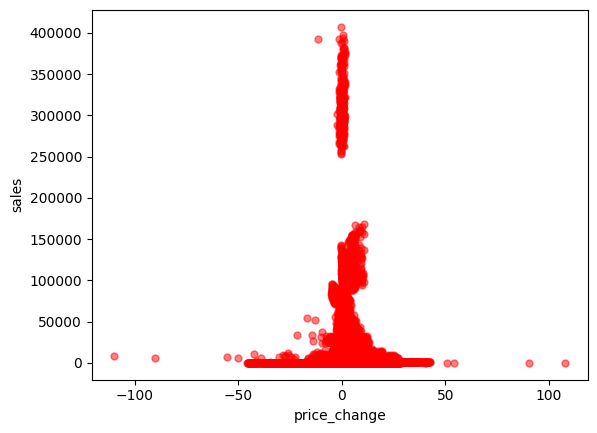

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot with sampling for better visualization
# Sample data to avoid plotting 100k+ points
sample_df = df.sample(n=min(5000, len(df)), random_state=42)
plt.scatter(sample_df['price_change'], sample_df['sales'], alpha=0.3, s=10)
plt.xlabel('Price Change (cents per kWh)')
plt.ylabel('Sales (MWh)')
plt.title('Price Change vs Sales (Sampled)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()